<h1 style="text-align: center;"><b>Loss functions for Faces Classification</b></h1>

При построении и обучени сети в [предыдущем блокноте](https://github.com/ivantipow/Face-Recognition/blob/main/1.%20NN%20for%20Faces%20Classification.ipynb) в качестве функции потерь мы использовали кросс энтропию.  На самом деле существует гораздо больше вариантов лоссов, которые можно использовать для обучения нейронной сети. В этом блокноте мы имплементируем два популярных лосса, которые часто используют в задачах распознавания лиц: **Triplet Loss** и **ArcFace Loss**, а также обучим нашу сеть с ними.

Больше примеров функций потерь для решения задачи распознавания лиц, а также обзоры их эффективности есть статье: https://arxiv.org/pdf/1901.05903.pdf.



---
<a id=''></a>
## Содержание

- [⚒ Подготовка окружения](#environment)

- [📚 Подготовка данных](#data)

    - [💾 Загрузка данных](#download)

    - [🖼 Визуализация изображений](#visuaL)

    - [⛓ Dataset & Dataloader](#dataloader)
   
- [📉 Triplet Loss](#triplet)

    - [🗣 Про лосс](#thr_triplet)

    - [⚙ Построение и обучение модели](#build_train)

        - [🏎 Inception Resnet V1](#inception)

        - [🧠 Обучение модели](#train)

<a id='environment'></a>
## ⚒ Подготовка окружения
Импортируем необходимые библиотеки

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
import pandas as pd
import random
import copy
from tqdm import tqdm
import torchsummary
import os
import pickle
import cv2
import numpy as np
from PIL import Image
from skimage import io, transform

import torch
import torchvision.transforms as transforms
from torchvision.transforms import functional
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch import nn

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [ ]:
def set_seed(seed):
    """Установить зерно генераторов случайных чисел"""

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)


def seed_worker(worker_id):
    """Воспроизводимость DataLoader'a (см. ссылку выше)"""

    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


set_seed(42)

Вычисления будем проводить на GPU

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()
print(DEVICE)
!nvidia-smi

cuda
Sun Jan 30 17:50:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    33W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+--

Далее будем сохранять лучшие модели на Google Диск

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
DIR = '/content/gdrive/MyDrive/faceRec/Triplet'

os.makedirs(DIR, exist_ok=True)

<a id='data'></a>
## 📚 Подготовка данных

В качестве обучающей выборки возьмем часть датасета [CelebA dataset](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). Далее мы будем использовать его версию, в которой все изображения выровнены и обрезаны. Этот набор данных можно скачать по [ссылке](https://disk.yandex.ru/d/FVFucEDrZaxI9g).

<a id='download'></a>
### 💾 Загрузка данных

In [ ]:
# Эта ссылка не будет работать для вас. Если вы хотите сгенерировать рабочую ссылку,
# посетите https://askubuntu.com/questions/1188381/how-to-get-link-of-file-to-download-with-wget
# или скачайте данные и поместите их в папку вручную
! wget "https://s765sas.storage.yandex.net/rdisk/36f14fddc3de6a8bf0547d156945b443c4d91b56eaa1f9225ce7469cb05777fd/61f6ef19/aZ8Akc9CqtcaAMvg9MkExb-ZXFJYNWenUWJ_dbR92U4Li0Fm9ILKkVrnJJYE3VZWsNkdU6Gc2QUgXQTMgBkqjw==?uid=0&filename=celebA_train_1k.zip&disposition=attachment&hash=PfmOewm6R2ULQcsn/YzTYJAc1RAPeCDt%2Bp28Gx92u6wDzG5HjZYUVPYC93xmi%2BwEq/J6bpmRyOJonT3VoXnDag%3D%3D&limit=0&content_type=application%2Fzip&owner_uid=316082386&fsize=179856800&hid=f0124eac823ad5b8355d598606e9183d&media_type=compressed&tknv=v2&rtoken=oA9av8C6PiZ0&force_default=no&ycrid=na-f861054831487eac56eacecc0e1b84a9-downloader1f&ts=5d6d229d73840&s=ab22fd5733f0c40a883af7e333ba09ba19ab6e085c310ef3bee3c256ac54fba6&pb=U2FsdGVkX1-WeajwXBWHSV3TFryOHZ-4pDM-GnBexDcehhC8AXnz55Lf6JjyH4uyah2ABM9k8St5e9GMCwvn0t1QAwPaqhGDIJdNFIMqk40" - O celebA.zip
! unzip -q celebA.zip

Давайте посмотрим на данные:

In [ ]:
! ls celebA_train_1k/

celebA_anno.txt  celebA_imgs  celebA_train_split.txt


- celebA_imgs — папка с выровненными изображениями 
- celebA_anno.txt — файл с аннотациями: какому человеку соответствует каждое изображение
- celebA_train_split.txt — файл с информацией о train/val/test

<a id='visuaL'></a>
### 🖼 Визуализация изображений

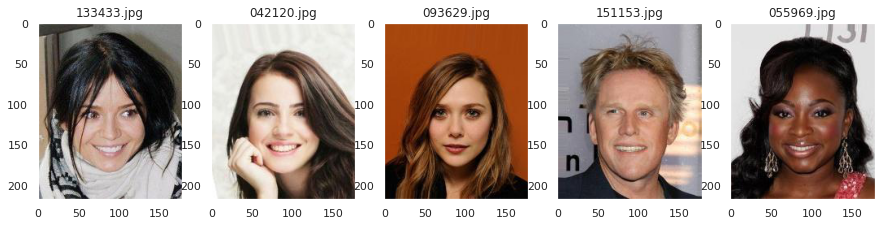

In [ ]:
def show_imgs(images_names):
    imgs = []
    for img in images_names:
        img = Image.open(os.path.join('celebA_train_1k/celebA_imgs/', img))
        imgs.append(np.array(img))

    f, axes = plt.subplots(1, len(imgs), figsize=(3*len(imgs), 5))
    for i, axis in enumerate(axes):
        axes[i].imshow(imgs[i])
        axes[i].set_title(images_names[i])
        axes[i].grid(None)
    plt.show()


images_names = os.listdir('./celebA_train_1k/celebA_imgs/')[:5]
show_imgs(images_names)

<a id='dataloader'></a>
### ⛓ Dataset & Dataloader

In [ ]:
def get_paths(dataset_type='train'):
    '''
    a function that returnes list of images paths for a given type of the dataset
    params:
      dataset_type: one of 'train', 'val', 'test'
    '''

    labels_dict = {
        'train': 0,
        'val': 1,
        'test': 2,
    }

    f = open('celebA_train_1k/celebA_train_split.txt', 'r')
    lines = f.readlines()
    f.close()

    lines = [x.strip().split() for x in lines]
    lines = [x[0] for x in lines if int(x[1]) == labels_dict[dataset_type]]

    images_paths = []
    for filename in lines:
        images_paths.append(os.path.join(
            'celebA_train_1k/celebA_imgs/', filename))

    return np.array(images_paths)

Создадим Dataset'ы

In [ ]:
class celebADataset(Dataset):

    def __init__(self, dataset_type, transform, aug=None,):
        self.images = get_paths(dataset_type=dataset_type)

        f = open('celebA_train_1k/celebA_anno.txt', 'r')
        labels = f.readlines()
        f.close()

        labels = [x.strip().split() for x in labels]
        labels = {x: int(y) for x, y in labels}
        self.labels = [labels[x.split('/')[-1]] for x in self.images]

        self.transform = transform
        self.aug = aug

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        label = self.labels[idx]

        image = Image.open(img_name)

        if self.aug:
            sample = self.aug(
                image=image,
            )
        else:
            sample = {
                'image': image,
                'label': label,
            }

        sample['image'] = self.transform(sample['image'])

        return sample

In [ ]:
class FaceTransform:
    """Transform and augmentation."""

    def __init__(self, im_size=0, y_frame=65, x_frame=35):
        self.im_size = im_size
        self.y_frame = y_frame
        self.x_frame = x_frame

    def __call__(self, x):
        # input size: 218 x 178
        im_size = self.im_size
        y_frame = self.y_frame
        x_frame = self.x_frame

        img = functional.crop(
            x, y_frame, x_frame, int(218-1.52*y_frame), 178-2*x_frame)
        if im_size:
            img = functional.resize(img, im_size)
        img = functional.to_tensor(img)
        img = functional.normalize(
            img, (0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

        return img


transform = FaceTransform()

train_data = celebADataset('train', transform)
val_data = celebADataset('val', transform)
test_data = celebADataset('test', transform)

Создадим Dataloader'ы

In [ ]:
batch_size = 64
train_loader = DataLoader(train_data, batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


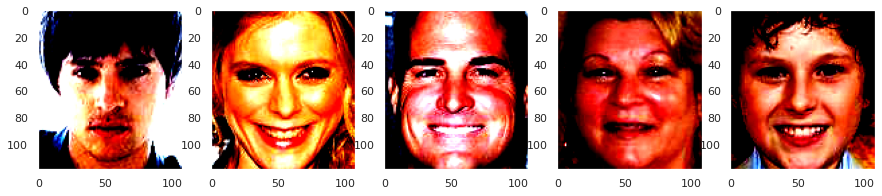

In [ ]:
num_img = 5
trans_img = np.rollaxis(next(iter(train_loader))[
                        'image'].numpy(), 1, 4)[:num_img]

f, axes = plt.subplots(1, 5, figsize=(3*5, 5))
for i, axis in enumerate(axes):
    axes[i].imshow(trans_img[i])
    axes[i].grid(None)
plt.show()

<a id='triplet'></a>
## 📉 Triplet Loss

<a id='thr_triplet'></a>
### 🗣 Про лосс

Triplet Loss - это еще один вид функций потерь, который не требует наличия в модели последнего слоя классификации - он работает непосредственно с эмбеддингами. Этот лосс требует, чтобы эмбеддинги одного человека были близки в пространстве эмбеддингов, а эмбеддинги разных людей были далеки друг от друга.

Эта функция потерь имеет преимущество перед CE-подобными потерями: она не зависит от количества классов в наборе данных. Если в наборе данных появятся лица новых людей, нам не нужно будет полностью переобучать сеть, мы можем просто дообучить уже обученную сеть на новых фотографиях.

**Как работает TripletLoss**:

Архитектура нейронной сети будет несколько иной, чем при использовании CE loss'а: у нее не будет последнего слоя классификации. Последний слой NN будет выводить эмбеддинги для данной фотографии

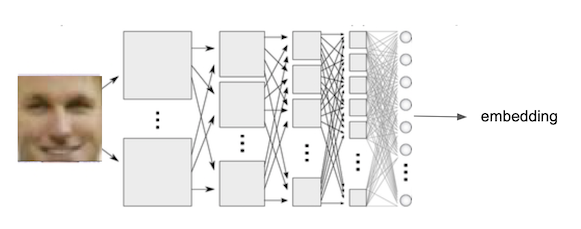

TripletLoss работает непосредственно с этими эмбеддингами. Его идея заключается в том, чтобы сделать эмбеддинги одних и тех же людей более близкими, компактными в пространстве эмбеддингов, а эмбеддинги разных людей - более разделёнными. Формула для данного лосса:


$$L(a, p, n) = max\{d(a, p) - d(a, n) + margin, 0\},$$

где 
- $a$ эмбеддинг для фотографии (выход модели)
- $p$ positive эмбеддинг для фотографии (эмбеддинг, который мы хотим, чтобы был близок к $a$)
- $n$ negative эмбеддинг для фотографии (эмбеддинг, который мы хотим, чтобы был далёк от $a$)
- $d(x, y)$ мера расстояния между эмбеддингами 
- margin — положительная величина, чтобы еще больше увеличить разницу между $d(a, p)$ и $d(a, n)$

Все эмбеддинги $a$, $p$ и $n$ должны быть нормированы перед подачей в лосс.

В нашем случае для некоторой фотографии: $a$ - ее эмбеддинг, positive эмбеддинг $p$ должен быть эмбеддингом фотографии того же человека, а negative эмбеддинг $n$ должен быть эмбеддингом фотографии другого человека.

Имплементацию TripletLoss'а на PyTorch можно найти [здесь](https://pytorch.org/docs/stable/generated/torch.nn.TripletMarginWithDistanceLoss.html#torch.nn.TripletMarginWithDistanceLoss). Существуют различные варианты TripletLoss'а, которые также могут повысить производительность:
- использовать больше, чем 1 пример $p$ и $n$ для одного эмбеддинга $a$ 
- использовать специальные виды negative эмбеддингов, например, $n$, которые находятся наиболее близко к $a$ (для усиления их удаленности от $a$)

**Что будем делать мы?**

Создадим модель и обучим ее с помощью TripletLoss'а при различных значениях margin. В качестве меры расстояния между эмбеддингами $d(x, y)$ будем использовать функцию $1 - CosineSimilarity(x, y)$, поскольку, чем больше косинусное расстояние, тем ближе эмбеддинги.

*Чтобы не было путаницы, дальше в этом пункте векторами я буду называть то, что мы получаем на выходе feature extractor'а, а эмбеддингами то, что получаем на выходе fully connected части.*

Непосредственно для обучения сети мы поступим следующим образом:

1. Поскольку feature extractor (convolution часть нашей сети) мы не дообучаем, то для получения векторного представления наших фотографий мы можем пропустить их все через feature extractor часть нашей сети. 

2. Далее мы можем посчитать для каждого человека (класса) из нашей базы данных средний ("опорный") вектор. 

3. После этого мы будем подавать на вход fully connected части нашей сети: вектор для случайного человека, позитивный вектор для него (средний вектор для класса этого человека), а также негативный вектор (средний вектор для человека из другого класса). На выходе, соответственно, получим эмбеддинги $a$, $p$ и $n$.

4. Считаем лосс и обучаем модель.

<a id='build_train'></a>
## ⚙ Построение и обучение модели

<a id='inception'></a>
### 🏎 Inception Resnet V1
Далее мы будем использовать предобученную на VGGFace2 сеть InceptionResnetV1: https://github.com/timesler/facenet-pytorch/tree/master/models

In [ ]:
! git clone https://github.com/timesler/facenet-pytorch.git
! mv facenet-pytorch/models ./

fatal: destination path 'facenet-pytorch' already exists and is not an empty directory.
mv: cannot stat 'facenet-pytorch/models': No such file or directory


In [ ]:
! ls models

inception_resnet_v1.py	mtcnn.py  __pycache__  utils


In [ ]:
from models import inception_resnet_v1

Мы будем файнтюнить только последние FC-слои. Потому разобьем нейронную сеть на Feature Extractor и Fully-connected части

In [ ]:
def get_model():

    feature_extractor = inception_resnet_v1.InceptionResnetV1(
        pretrained='vggface2',
        classify=False, num_classes=None
    ).to(DEVICE)

    # feature_extractor.dropout = nn.Identity()
    feature_extractor.last_linear = nn.Identity()
    feature_extractor.last_bn = nn.Identity()
    feature_extractor.logits = nn.Identity()

    full_con = inception_resnet_v1.InceptionResnetV1(
        pretrained='vggface2',
        classify=False, num_classes=None
    ).to(DEVICE)

    full_con.conv2d_1a = nn.Identity()
    full_con.conv2d_2a = nn.Identity()
    full_con.conv2d_2b = nn.Identity()
    full_con.maxpool_3a = nn.Identity()
    full_con.conv2d_3b = nn.Identity()
    full_con.conv2d_4a = nn.Identity()
    full_con.conv2d_4b = nn.Identity()
    full_con.repeat_1 = nn.Identity()
    full_con.mixed_6a = nn.Identity()
    full_con.repeat_2 = nn.Identity()
    full_con.mixed_7a = nn.Identity()
    full_con.repeat_3 = nn.Identity()
    full_con.block8 = nn.Identity()
    full_con.avgpool_1a = nn.Identity()
    full_con.dropout = nn.Identity()

    model = dict()
    model['fc'] = full_con
    model['fe'] = feature_extractor

    return model

In [ ]:
model_trplt = get_model()

In [ ]:
def get_embeddings(model, data_loader):
    model.eval()
    embeddings = {}

    for batch in data_loader:
        inputs = batch['image'].to(DEVICE)
        labels = batch['label'].to(DEVICE)
        with torch.no_grad():
            outputs = model(inputs)
        for label, vector in zip(labels, outputs):
            label = int(label)
            if label in embeddings:
                embeddings[label] = torch.cat((embeddings[label], vector))
            else:
                embeddings[label] = vector

    for label in embeddings.keys():
        embeddings[label] = embeddings[label].view(-1, 1792)

    return embeddings

Получим вектора после прохода через feature extractor

In [ ]:
train_embs = get_embeddings(model_trplt['fe'], train_loader)
val_embs = get_embeddings(model_trplt['fe'], val_loader)
test_embs = get_embeddings(model_trplt['fe'], test_loader)

In [ ]:
len(train_embs), len(val_embs), len(test_embs)

(1000, 992, 976)

In [ ]:
# Запишем векторы в словарь
with open(os.path.join(DIR, 'train_embs.pickle'), 'wb') as f:
    pickle.dump(train_embs, f)

with open(os.path.join(DIR, 'val_embs.pickle'), 'wb') as f:
    pickle.dump(val_embs, f)

with open(os.path.join(DIR, 'test_embs.pickle'), 'wb') as f:
    pickle.dump(test_embs, f)

In [ ]:
# Загрузим векторы
with open(os.path.join(DIR, 'train_embs.pickle'), 'rb') as f:
    train_embs = pickle.load(f)

with open(os.path.join(DIR, 'val_embs.pickle'), 'rb') as f:
    val_embs = pickle.load(f)

with open(os.path.join(DIR, 'test_embs.pickle'), 'rb') as f:
    test_embs = pickle.load(f)

За основу для positive embedding'ов возьмем средний вектор картинок из тестового набора для каждого класса после прохода feature extractor'а. Далее этот positive embeding будет проходить через FC часть вместе с anchor вектором. 

In [ ]:
def get_mean_embeddings(embeddings):
    embddgs = dict()
    for label in embeddings.keys():
        embddgs[label] = embeddings[label].view(-1, 1792).mean(dim=0)

    return embddgs

In [ ]:
pos_embs = get_mean_embeddings(train_embs)

In [ ]:
# Запишем векторы в словарь
with open(os.path.join(DIR, 'pos_embs.pickle'), 'wb') as f:
    pickle.dump(pos_embs, f)

In [ ]:
# Загрузим векторы
with open(os.path.join(DIR, 'pos_embs.pickle'), 'rb') as f:
    pos_embs = pickle.load(f)

In [ ]:
class embeddingDataset(Dataset):

    def __init__(self, dict_embs, dict_pos_embs):
        self.keys = list(dict_embs.keys()).copy()
        self.dict_embs = dict_embs
        self.dict_pos_embs = dict_pos_embs
        lbls = []
        embs = []
        for lbl in dict_embs.keys():
            for emb in dict_embs[lbl]:
                lbls.append(lbl)
                embs.append(emb)
        self.lbls = lbls
        self.embs = embs

    def __len__(self):
        return len(self.lbls)

    def __getitem__(self, idx):
        emb = self.embs[idx]
        lbl = self.lbls[idx]
        pos = self.dict_pos_embs[lbl]
        neg_lbls = self.keys.copy()
        neg_lbls.remove(lbl)
        neg_lbl = random.choice(neg_lbls)
        neg = random.choice(self.dict_embs[neg_lbl])

        sample = {
            'emb': emb,
            'label': lbl,
            'pos': pos,
            'neg': neg,
        }

        return sample

In [ ]:
train_emb_data = embeddingDataset(train_embs, pos_embs)
val_emb_data = embeddingDataset(val_embs, pos_embs)
test_emb_data = embeddingDataset(test_embs, pos_embs)

In [ ]:
batch_size = 64
train_emb_loader = DataLoader(train_emb_data, batch_size, shuffle=True)
val_emb_loader = DataLoader(val_emb_data, batch_size, shuffle=False)
test_emb_loader = DataLoader(test_emb_data, batch_size, shuffle=False)

Для предсказания меток на основе "опорных" векторов

In [ ]:
labels_s = np.array(list(pos_embs.keys()))
labels_s.sort()

support_embs = torch.tensor(()).to(DEVICE)

for label in labels_s:
    support_embs = torch.cat((support_embs, pos_embs[label]))

support_embs = support_embs.view(-1, 1792).cpu().detach().numpy()

In [ ]:
def preds_labels(embs, model):
    sup_vctrs = model(torch.tensor(support_embs).to(
        DEVICE)).cpu().detach().numpy()
    mtx_cos_sim = cosine_similarity(embs, sup_vctrs)
    predicts = np.argmax(mtx_cos_sim, axis=1)

    return labels_s[predicts]

<a id='train'></a>
### 🧠 Обучение модели

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    size_data = 0

    for batch in train_loader:
        anch = batch['emb'].to(DEVICE)
        pos = batch['pos'].to(DEVICE)
        neg = batch['neg'].to(DEVICE)
        labels = batch['label'].to(DEVICE)

        optimizer.zero_grad()
        anchor = model(anch)
        positive = model(pos)
        negative = model(neg)

        loss = criterion(anchor, positive, negative)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * anch.size(0)
        preds = torch.tensor(preds_labels(
            anchor.cpu().detach().numpy(), model))
        running_corrects += torch.sum(preds.to(DEVICE) == labels.data)

        size_data += anch.size(0)

    train_loss = running_loss / size_data
    train_acc = running_corrects.cpu().numpy() / size_data

    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    size_data = 0

    for batch in val_loader:
        anch = batch['emb'].to(DEVICE)
        pos = batch['pos'].to(DEVICE)
        neg = batch['neg'].to(DEVICE)
        labels = batch['label'].to(DEVICE)

        with torch.set_grad_enabled(False):
            anchor = model(anch)
            positive = model(pos)
            negative = model(neg)
            loss = criterion(anchor, positive, negative)
            preds = torch.tensor(preds_labels(
                anchor.cpu().detach().numpy(), model))

        running_loss += loss.item() * anch.size(0)
        running_corrects += torch.sum(preds.to(DEVICE) == labels.data)
        size_data += anch.size(0)

    val_loss = running_loss / size_data
    val_acc = running_corrects.double() / size_data

    return val_loss, val_acc

In [ ]:
def train(train_loader, val_loader, model, epochs,
          optimizer, scheduler, criterion):

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(
                model, train_loader, criterion, optimizer)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            scheduler.step()
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,
                                           v_loss=val_loss, t_acc=train_acc,
                                           v_acc=val_acc))

    return history

In [ ]:
marg_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
margin = dict()
model_dict = {}
epochs = 10
for mrg in marg_list:
    print(mrg)
    model_trplt = get_model()
    optimizer = torch.optim.Adam(model_trplt['fc'].parameters(), lr=1e-6)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 5, 0.1)
    criterion = nn.TripletMarginWithDistanceLoss(
        distance_function=lambda x, y: 1.0 - F.cosine_similarity(x, y)
    )
    history = train(train_emb_loader, val_emb_loader, model_trplt['fc'], epochs,
                    optimizer, scheduler, criterion)
    margin[mrg] = history
    model_dict[mrg] = model_trplt

0.5


epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 0.28186093548196683


epoch:  10%|█         | 1/10 [00:06<00:56,  6.28s/it]


Epoch 001 train_loss: 0.2819     val_loss 0.3123 train_acc 0.8827 val_acc 0.8271
loss 0.2818569443863677


epoch:  20%|██        | 2/10 [00:12<00:49,  6.20s/it]


Epoch 002 train_loss: 0.2819     val_loss 0.3127 train_acc 0.8873 val_acc 0.8260
loss 0.2812023981557316


epoch:  30%|███       | 3/10 [00:18<00:43,  6.27s/it]


Epoch 003 train_loss: 0.2812     val_loss 0.3137 train_acc 0.8875 val_acc 0.8263
loss 0.2808515187656814


epoch:  40%|████      | 4/10 [00:25<00:37,  6.25s/it]


Epoch 004 train_loss: 0.2809     val_loss 0.3128 train_acc 0.8874 val_acc 0.8263
loss 0.27686825481214244


epoch:  50%|█████     | 5/10 [00:31<00:31,  6.24s/it]


Epoch 005 train_loss: 0.2769     val_loss 0.3110 train_acc 0.8878 val_acc 0.8274
loss 0.27651763462253487


epoch:  60%|██████    | 6/10 [00:37<00:25,  6.26s/it]


Epoch 006 train_loss: 0.2765     val_loss 0.3063 train_acc 0.8877 val_acc 0.8274
loss 0.27809847496893364


epoch:  70%|███████   | 7/10 [00:43<00:18,  6.26s/it]


Epoch 007 train_loss: 0.2781     val_loss 0.3094 train_acc 0.8878 val_acc 0.8276
loss 0.27678200291004634


epoch:  80%|████████  | 8/10 [00:49<00:12,  6.23s/it]


Epoch 008 train_loss: 0.2768     val_loss 0.3104 train_acc 0.8879 val_acc 0.8276
loss 0.278679728105687


epoch:  90%|█████████ | 9/10 [00:56<00:06,  6.21s/it]


Epoch 009 train_loss: 0.2787     val_loss 0.3083 train_acc 0.8880 val_acc 0.8279
loss 0.2784812757492849


epoch: 100%|██████████| 10/10 [01:02<00:00,  6.22s/it]



Epoch 010 train_loss: 0.2785     val_loss 0.3073 train_acc 0.8879 val_acc 0.8279
0.6


epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 0.2838144290823656


epoch:  10%|█         | 1/10 [00:06<00:55,  6.17s/it]


Epoch 001 train_loss: 0.2838     val_loss 0.3124 train_acc 0.8827 val_acc 0.8266
loss 0.28249244152107267


epoch:  20%|██        | 2/10 [00:12<00:49,  6.19s/it]


Epoch 002 train_loss: 0.2825     val_loss 0.3166 train_acc 0.8868 val_acc 0.8268
loss 0.28127635469849727


epoch:  30%|███       | 3/10 [00:18<00:43,  6.19s/it]


Epoch 003 train_loss: 0.2813     val_loss 0.3073 train_acc 0.8877 val_acc 0.8282
loss 0.28050156784443836


epoch:  40%|████      | 4/10 [00:24<00:37,  6.22s/it]


Epoch 004 train_loss: 0.2805     val_loss 0.3107 train_acc 0.8877 val_acc 0.8284
loss 0.27989553260906774


epoch:  50%|█████     | 5/10 [00:31<00:31,  6.22s/it]


Epoch 005 train_loss: 0.2799     val_loss 0.3078 train_acc 0.8875 val_acc 0.8287
loss 0.27966658578104836


epoch:  60%|██████    | 6/10 [00:37<00:24,  6.19s/it]


Epoch 006 train_loss: 0.2797     val_loss 0.3121 train_acc 0.8880 val_acc 0.8284
loss 0.27841734265564666


epoch:  70%|███████   | 7/10 [00:43<00:18,  6.19s/it]


Epoch 007 train_loss: 0.2784     val_loss 0.3108 train_acc 0.8879 val_acc 0.8284
loss 0.27849519570950737


epoch:  80%|████████  | 8/10 [00:49<00:12,  6.16s/it]


Epoch 008 train_loss: 0.2785     val_loss 0.3066 train_acc 0.8879 val_acc 0.8284
loss 0.276527738075103


epoch:  90%|█████████ | 9/10 [00:55<00:06,  6.16s/it]


Epoch 009 train_loss: 0.2765     val_loss 0.3079 train_acc 0.8879 val_acc 0.8284
loss 0.27776448881840227


epoch: 100%|██████████| 10/10 [01:01<00:00,  6.17s/it]



Epoch 010 train_loss: 0.2778     val_loss 0.3045 train_acc 0.8879 val_acc 0.8284
0.7


epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 0.2838670975068517


epoch:  10%|█         | 1/10 [00:06<00:54,  6.08s/it]


Epoch 001 train_loss: 0.2839     val_loss 0.3143 train_acc 0.8833 val_acc 0.8260
loss 0.2836331232659819


epoch:  20%|██        | 2/10 [00:12<00:49,  6.13s/it]


Epoch 002 train_loss: 0.2836     val_loss 0.3146 train_acc 0.8871 val_acc 0.8266
loss 0.28066448095063395


epoch:  30%|███       | 3/10 [00:18<00:42,  6.11s/it]


Epoch 003 train_loss: 0.2807     val_loss 0.3108 train_acc 0.8874 val_acc 0.8268
loss 0.27871933450006464


epoch:  40%|████      | 4/10 [00:24<00:36,  6.11s/it]


Epoch 004 train_loss: 0.2787     val_loss 0.3131 train_acc 0.8877 val_acc 0.8274
loss 0.2771378464997689


epoch:  50%|█████     | 5/10 [00:30<00:30,  6.10s/it]


Epoch 005 train_loss: 0.2771     val_loss 0.3058 train_acc 0.8877 val_acc 0.8279
loss 0.2784144401354386


epoch:  60%|██████    | 6/10 [00:36<00:24,  6.11s/it]


Epoch 006 train_loss: 0.2784     val_loss 0.3095 train_acc 0.8878 val_acc 0.8282
loss 0.2777645901756844


epoch:  70%|███████   | 7/10 [00:42<00:18,  6.15s/it]


Epoch 007 train_loss: 0.2778     val_loss 0.3155 train_acc 0.8879 val_acc 0.8282
loss 0.2779183849746569


epoch:  80%|████████  | 8/10 [00:49<00:12,  6.15s/it]


Epoch 008 train_loss: 0.2779     val_loss 0.3091 train_acc 0.8880 val_acc 0.8282
loss 0.2776438769340963


epoch:  90%|█████████ | 9/10 [00:55<00:06,  6.14s/it]


Epoch 009 train_loss: 0.2776     val_loss 0.3091 train_acc 0.8880 val_acc 0.8282
loss 0.27491203121196384


epoch: 100%|██████████| 10/10 [01:01<00:00,  6.13s/it]



Epoch 010 train_loss: 0.2749     val_loss 0.3060 train_acc 0.8881 val_acc 0.8282
0.8


epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 0.2819526515623846


epoch:  10%|█         | 1/10 [00:06<00:55,  6.13s/it]


Epoch 001 train_loss: 0.2820     val_loss 0.3163 train_acc 0.8815 val_acc 0.8257
loss 0.28378612456194097


epoch:  20%|██        | 2/10 [00:12<00:49,  6.15s/it]


Epoch 002 train_loss: 0.2838     val_loss 0.3127 train_acc 0.8873 val_acc 0.8260
loss 0.2818901597446001


epoch:  30%|███       | 3/10 [00:18<00:42,  6.13s/it]


Epoch 003 train_loss: 0.2819     val_loss 0.3101 train_acc 0.8873 val_acc 0.8266
loss 0.27756535117125786


epoch:  40%|████      | 4/10 [00:24<00:36,  6.12s/it]


Epoch 004 train_loss: 0.2776     val_loss 0.3117 train_acc 0.8877 val_acc 0.8268
loss 0.2787694520780438


epoch:  50%|█████     | 5/10 [00:30<00:30,  6.11s/it]


Epoch 005 train_loss: 0.2788     val_loss 0.3111 train_acc 0.8875 val_acc 0.8271
loss 0.2779379496028382


epoch:  60%|██████    | 6/10 [00:36<00:24,  6.14s/it]


Epoch 006 train_loss: 0.2779     val_loss 0.3111 train_acc 0.8876 val_acc 0.8274
loss 0.27647351262532766


epoch:  70%|███████   | 7/10 [00:43<00:18,  6.19s/it]


Epoch 007 train_loss: 0.2765     val_loss 0.3116 train_acc 0.8875 val_acc 0.8274
loss 0.2754721512801771


epoch:  80%|████████  | 8/10 [00:49<00:12,  6.19s/it]


Epoch 008 train_loss: 0.2755     val_loss 0.3090 train_acc 0.8875 val_acc 0.8274
loss 0.2775360962841933


epoch:  90%|█████████ | 9/10 [00:55<00:06,  6.14s/it]


Epoch 009 train_loss: 0.2775     val_loss 0.3063 train_acc 0.8874 val_acc 0.8276
loss 0.2781229563960868


epoch: 100%|██████████| 10/10 [01:01<00:00,  6.14s/it]



Epoch 010 train_loss: 0.2781     val_loss 0.3121 train_acc 0.8875 val_acc 0.8276
0.9


epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 0.28260977766871775


epoch:  10%|█         | 1/10 [00:06<00:54,  6.06s/it]


Epoch 001 train_loss: 0.2826     val_loss 0.3166 train_acc 0.8831 val_acc 0.8260
loss 0.2821507919092164


epoch:  20%|██        | 2/10 [00:12<00:48,  6.04s/it]


Epoch 002 train_loss: 0.2822     val_loss 0.3164 train_acc 0.8871 val_acc 0.8260
loss 0.28139619579798236


epoch:  30%|███       | 3/10 [00:18<00:42,  6.05s/it]


Epoch 003 train_loss: 0.2814     val_loss 0.3135 train_acc 0.8873 val_acc 0.8271
loss 0.27922993793091816


epoch:  40%|████      | 4/10 [00:24<00:36,  6.06s/it]


Epoch 004 train_loss: 0.2792     val_loss 0.3145 train_acc 0.8875 val_acc 0.8279
loss 0.2796756464252031


epoch:  50%|█████     | 5/10 [00:30<00:30,  6.04s/it]


Epoch 005 train_loss: 0.2797     val_loss 0.3093 train_acc 0.8880 val_acc 0.8287
loss 0.2783357072588787


epoch:  60%|██████    | 6/10 [00:36<00:24,  6.02s/it]


Epoch 006 train_loss: 0.2783     val_loss 0.3100 train_acc 0.8882 val_acc 0.8284
loss 0.27827605803830896


epoch:  70%|███████   | 7/10 [00:42<00:18,  6.01s/it]


Epoch 007 train_loss: 0.2783     val_loss 0.3077 train_acc 0.8882 val_acc 0.8284
loss 0.2794321251105837


epoch:  80%|████████  | 8/10 [00:48<00:12,  6.03s/it]


Epoch 008 train_loss: 0.2794     val_loss 0.3162 train_acc 0.8883 val_acc 0.8284
loss 0.2781595179649541


epoch:  90%|█████████ | 9/10 [00:54<00:06,  6.07s/it]


Epoch 009 train_loss: 0.2782     val_loss 0.3031 train_acc 0.8882 val_acc 0.8284
loss 0.27816024388012045


epoch: 100%|██████████| 10/10 [01:00<00:00,  6.04s/it]



Epoch 010 train_loss: 0.2782     val_loss 0.3105 train_acc 0.8882 val_acc 0.8284
1.0


epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 0.2831092292307576


epoch:  10%|█         | 1/10 [00:06<00:54,  6.07s/it]


Epoch 001 train_loss: 0.2831     val_loss 0.3169 train_acc 0.8828 val_acc 0.8266
loss 0.28193348107420235


epoch:  20%|██        | 2/10 [00:12<00:48,  6.07s/it]


Epoch 002 train_loss: 0.2819     val_loss 0.3130 train_acc 0.8871 val_acc 0.8271
loss 0.28041573746731363


epoch:  30%|███       | 3/10 [00:18<00:42,  6.05s/it]


Epoch 003 train_loss: 0.2804     val_loss 0.3125 train_acc 0.8873 val_acc 0.8274
loss 0.28187134028817445


epoch:  40%|████      | 4/10 [00:24<00:36,  6.09s/it]


Epoch 004 train_loss: 0.2819     val_loss 0.3074 train_acc 0.8882 val_acc 0.8274
loss 0.2789045008139258


epoch:  50%|█████     | 5/10 [00:30<00:30,  6.13s/it]


Epoch 005 train_loss: 0.2789     val_loss 0.3070 train_acc 0.8884 val_acc 0.8290
loss 0.2785567271239266


epoch:  60%|██████    | 6/10 [00:36<00:24,  6.11s/it]


Epoch 006 train_loss: 0.2786     val_loss 0.3082 train_acc 0.8880 val_acc 0.8290
loss 0.27757122058280126


epoch:  70%|███████   | 7/10 [00:42<00:18,  6.11s/it]


Epoch 007 train_loss: 0.2776     val_loss 0.3079 train_acc 0.8879 val_acc 0.8287
loss 0.27809564587529495


epoch:  80%|████████  | 8/10 [00:48<00:12,  6.10s/it]


Epoch 008 train_loss: 0.2781     val_loss 0.3135 train_acc 0.8879 val_acc 0.8290
loss 0.2768666261146992


epoch:  90%|█████████ | 9/10 [00:54<00:06,  6.08s/it]


Epoch 009 train_loss: 0.2769     val_loss 0.3067 train_acc 0.8879 val_acc 0.8290
loss 0.2752126261639139


epoch: 100%|██████████| 10/10 [01:00<00:00,  6.09s/it]


Epoch 010 train_loss: 0.2752     val_loss 0.3138 train_acc 0.8878 val_acc 0.8290


In [ ]:
t_loss = dict()
v_loss = dict()
t_acc = dict()
v_acc = dict()

for mrgn in marg_list:
    t_loss[mrgn], t_acc[mrgn], v_loss[mrgn], v_acc[mrgn] = zip(*margin[mrgn])

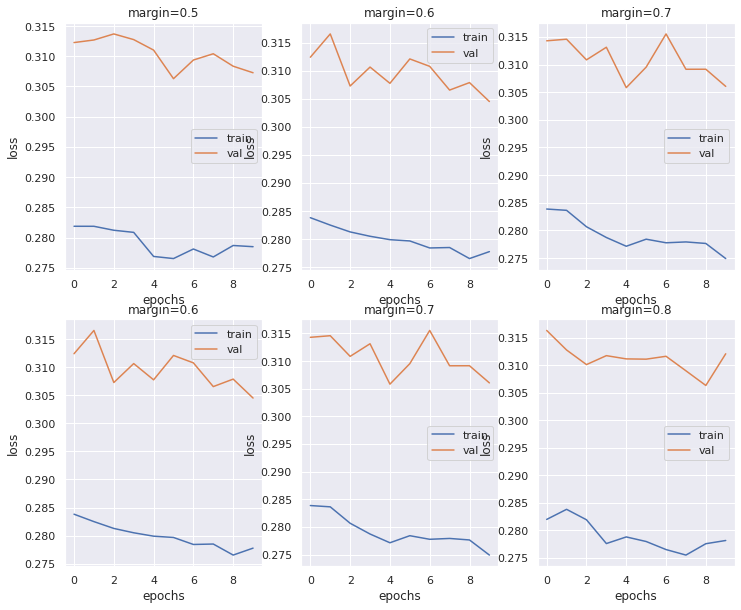

In [ ]:
col = 3
row = 2
f, axes = plt.subplots(2, col, figsize=(4*col, 5*row))
for r in range(row):
    for c in range(col):
        axes[r][c].plot(t_loss[marg_list[r+c]], label="train")
        axes[r][c].plot(v_loss[marg_list[r+c]], label="val")
        axes[r][c].set_title("margin="+str(marg_list[r+c]))
        axes[r][c].set_xlabel("epochs")
        axes[r][c].set_ylabel("loss")
        axes[r][c].legend(loc='best')

plt.show()

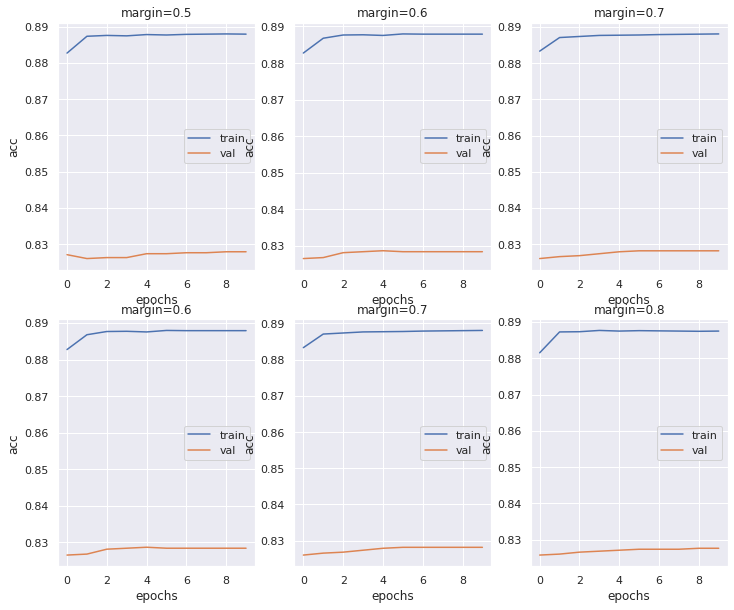

In [ ]:
col = 3
row = 2
f, axes = plt.subplots(2, col, figsize=(4*col, 5*row))
for r in range(row):
    for c in range(col):
        axes[r][c].plot(t_acc[marg_list[r+c]], label="train")
        axes[r][c].plot(v_acc[marg_list[r+c]], label="val")
        axes[r][c].set_title("margin="+str(marg_list[r+c]))
        axes[r][c].set_xlabel("epochs")
        axes[r][c].set_ylabel("acc")
        axes[r][c].legend(loc='best')

plt.show()

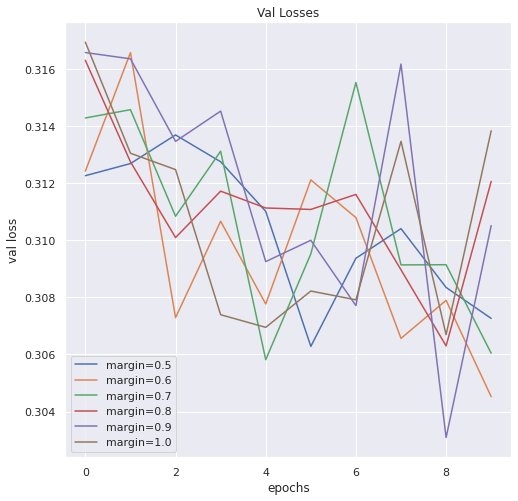

In [ ]:
plt.figure(figsize=(8, 8))
for mrg in marg_list:
    plt.plot(v_loss[mrg], label="margin="+str(mrg))
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("val loss")
plt.title("Val Losses")
plt.show()

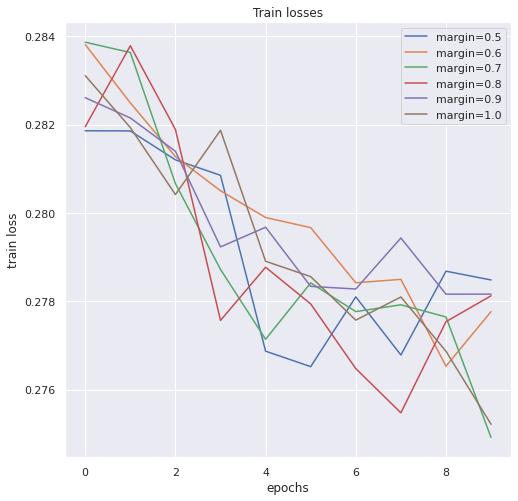

In [ ]:
plt.figure(figsize=(8, 8))
for mrg in marg_list:
    plt.plot(t_loss[mrg], label="margin="+str(mrg))
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("train loss")
plt.title("Train losses")
plt.show()

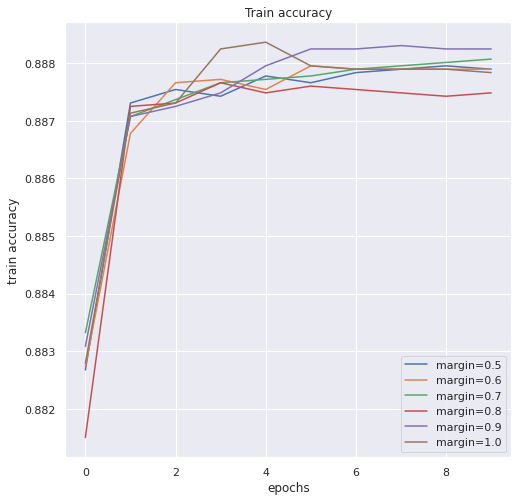

In [ ]:
plt.figure(figsize=(8, 8))
for mrg in marg_list:
    plt.plot(t_acc[mrg], label="margin="+str(mrg))
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("train accuracy")
plt.title("Train accuracy")
plt.show()

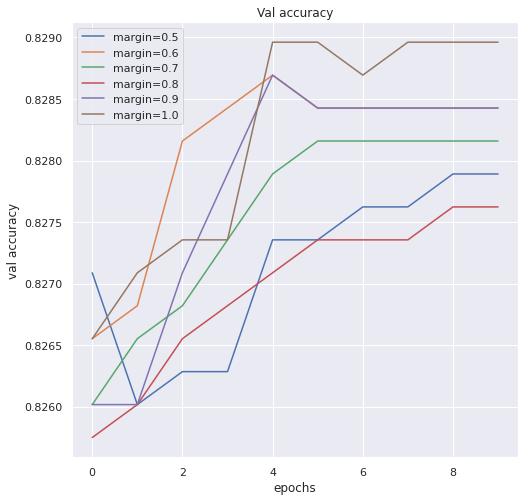

In [ ]:
plt.figure(figsize=(8, 8))
for mrg in marg_list:
    plt.plot(v_acc[mrg], label="margin="+str(mrg))
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("val accuracy")
plt.title("Val accuracy")
plt.show()

In [ ]:
for mrg in marg_list:
    _, test_acc = eval_epoch(model_dict[mrg]['fc'], test_emb_loader, criterion)
    print(f'Test Accuracy: {test_acc:0.4f} (margin = {mrg})')

Test Accuracy: 0.8138 (margin = 0.5)
Test Accuracy: 0.8141 (margin = 0.6)
Test Accuracy: 0.8154 (margin = 0.7)
Test Accuracy: 0.8144 (margin = 0.8)
Test Accuracy: 0.8160 (margin = 0.9)
Test Accuracy: 0.8147 (margin = 1.0)


Best model

In [ ]:
# Сохранить веса нейросети
model_weights_fc = copy.deepcopy(model_dict[0.9]['fc'].state_dict())
torch.save(model_weights_fc, DIR + '/model_weights_fc.pth')

In [ ]:
# Загрузить веса нейросети
model_trplt['fc'].load_state_dict(torch.load(DIR + '/model_weights_fc.pth'))

<All keys matched successfully>

# ArcFace Loss
to be continued....